# Transformations Tutorial #1: Coordinate Systems
## Introduction

This tutorial is about the transformation packages `LocalCoordinateSystem` class which describes the orientation and position of a Cartesian coordinate system towards another reference coordinate system. The reference coordinate systems origin is always at $(0, 0, 0)$ and its orientation is described by the basis: $e_x = (1, 0, 0)$, $e_y = (0, 1, 0)$, $e_z = (0, 0, 1)$.

## Imports
The packages required in this tutorial are:

In [1]:
# if the package is not installed in your python environment, run this to execute the notebook directly from inside the GitHub repository
%cd -q ..

In [2]:
# enable interactive plots on Jupyterlab with ipympl and jupyterlab-matplotlib installed
# %matplotlib widget

In [3]:
# plotting
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
import matplotlib.pyplot as plt

# interactive plots
import ipywidgets as widgets
from ipywidgets import VBox, HBox, IntSlider, Checkbox, interactive_output, FloatSlider
from IPython.display import display

import numpy as np
import pandas as pd
import xarray as xr

import weldx.visualization as vs
import weldx.transformations as tf

## Construction

The constructor of the `LocalCoordinateSystem` class takes 2 parameters, the `orientation` and the `coordinates`. `orientation` is a 3x3 matrix. It can either be viewed as a rotation/reflection matrix or a set of normalized column vectors that represent the 3 basis vectors of the coordinate system. The matrix needs to be orthogonal, otherwise, an exception is raised. `coordinates` is the position of the local coordinate systems origin inside the reference coordinate system. The default parameters are the identity matrix and the zero vector. Hence, we get a system that is identical to the reference system if no parameter is passed to the constructor.

In [4]:
lcs_ref = tf.LocalCoordinateSystem()

We create some coordinate systems and visualize them using the `visualization` package. The coordinate axes are colored as follows:

- x = red
- y = green
- z = blue

In [5]:
# create a translated coordinate system
lcs_01 = tf.LocalCoordinateSystem(coordinates=[2, 4, -1])

# create a rotated coordinate system using a rotation matrix as basis
rotation_matrix = tf.rotation_matrix_z(np.pi / 3)
lcs_02 = tf.LocalCoordinateSystem(orientation=rotation_matrix, coordinates=[0, 0, 3])

**Plot:**

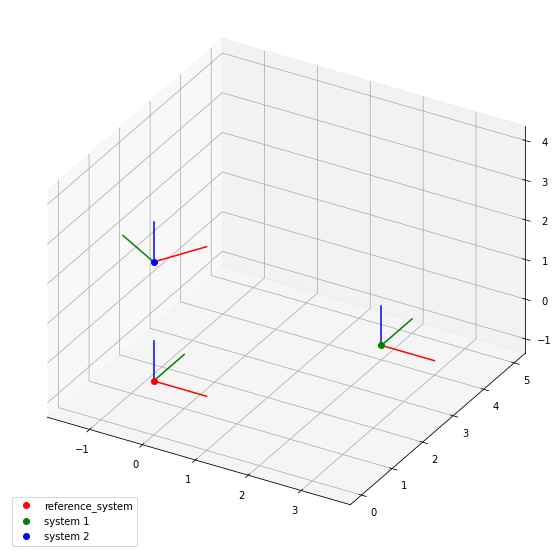

In [6]:
vs.plot_coordinate_systems([(lcs_ref, {"color":"r", "label":"reference_system"}), 
                            (lcs_01, {"color":"g", "label":"system 1"}), 
                            (lcs_02, {"color":"b", "label":"system 2"}) ])

> **HINT:** In the jupyter notebook version of this tutorial, you can rotate the plot by pressing the left mouse button and moving the mouse. This helps to understand how the different coordinate systems are positioned in the 3d space.

Apart from the class constructor, there are some factory functions implemented to create a coordinate system. The `from_orientation` provides the same functionality as the class constructor. The `from_xyz` takes 3 basis vectors instead of a matrix. `from_xy_and_orientation`, `from_xz_and_orientation` and `from_yz_and_orientation` create a coordinate system with 2 basis vectors and a `bool` which specifies if the coordinate system should have a positive or negative orientation. Here are some examples:

In [7]:
# coordinate system using 3 basis vectors
e_x = [1, 2, 0]
e_y = [-2, 1, 0]
e_z = [0, 0, 5]
lcs_03 = tf.LocalCoordinateSystem.from_xyz(e_x, e_y, e_z, coordinates=[1, 1, 0])

# create a negatively oriented coordinate system with 2 vectors
lcs_04 = tf.LocalCoordinateSystem.from_yz_and_orientation(
    e_y, e_z, positive_orientation=False, coordinates=[1, 1, 2]
)

**Plot:**

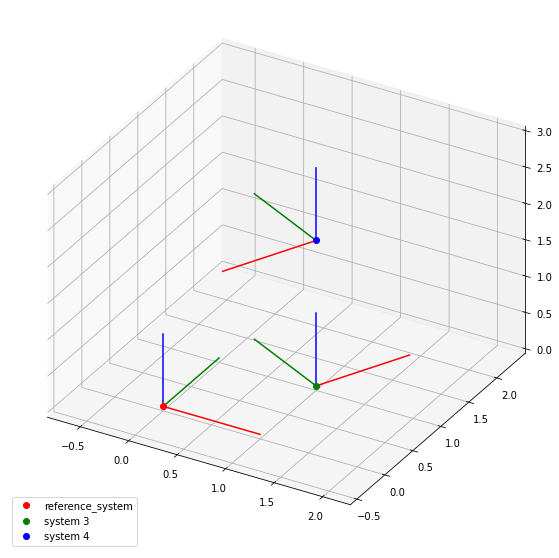

In [8]:
vs.plot_coordinate_systems([(lcs_ref, {"color":"r", "label":"reference_system"}), 
                            (lcs_03, {"color":"g", "label":"system 3"}), 
                            (lcs_04, {"color":"b", "label":"system 4"}) ])

As you can see, the y- and z-axis of system 3 and 4 are pointing into the same direction, since we used the same basis vectors. The automatically determined x axis of system 4 points into the opposite direction, since we wanted a system with negative orientation.

Another method to create a `LocalCoordinateSystem` is `from_euler`. It utilizes the `scipy.spatial.transform.Rotation.from_euler` function to calculate a rotation matrix from Euler sequences and uses it to describe the orientation of the coordinate system. The parameters `sequence`, `angles`, and `degrees` of the `from_euler` method are directly passed to the SciPy function. `sequence` expects a string that determines the rotation sequence around the coordinate axes. For example `"xyz"`. `angles` is  a scalar or list of the corresponding number of angles and `degrees` a `bool` that specifies if the angles are provided in degrees (`degrees=True`) or radians (`degrees=False`). For further details, have a look at the [SciPy documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.transform.Rotation.from_euler.html) of the `from_euler` function. Here is a short example:

In [9]:
# create a coordinate system by a 90° rotation around the x axis and subsequent 45° rotation around the y axis
lcs_05 = tf.LocalCoordinateSystem.from_euler(sequence="x", angles=90, degrees=True, coordinates=[1, -1, 0])
lcs_06 = tf.LocalCoordinateSystem.from_euler(
    sequence="xy", angles=[90, 45], degrees=True, coordinates=[2, -2, 0]
)

**Plot:**

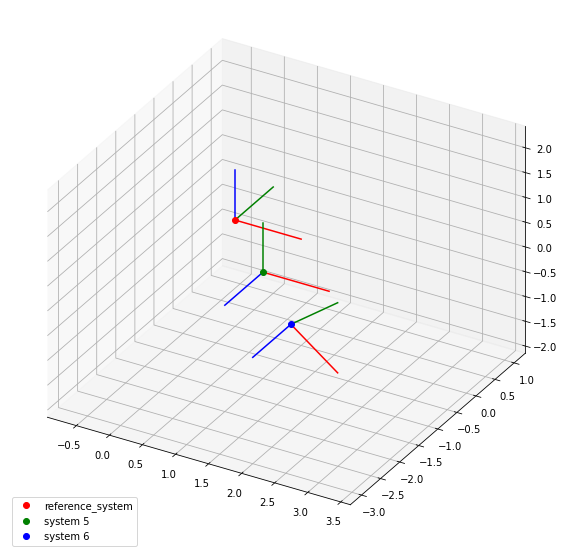

In [10]:
# create 3d plot
vs.plot_coordinate_systems([(lcs_ref, {"color":"r", "label":"reference_system"}), 
                            (lcs_05, {"color":"g", "label":"system 5"}), 
                            (lcs_06, {"color":"b", "label":"system 6"}) ])

## Coordinate transformations

It is quite common that there exists a chain or tree-like dependency between coordinate systems. We might have a moving object with a local coordinate system that describes its position and orientation towards a fixed reference coordinate system. This object can have another object attached to it, with its position and orientation given in relation to its parent objects coordinate system. If we want to know the attached object coordinate system in relation to the reference coordinate system, we have to perform a coordinate transformation.

To avoid confusion about the reference systems of each coordinate system, we will use the following naming convention for the coordinate systems: `lcs_NAME_in_REFERENCE`. This is a coordinate system with the name "NAME" and its reference system has the name "REFERENCE". The only exception to this convention will be the reference coordinate system "lcs_ref", which has no reference system.

The `LocalCoordinateSystem` class provides the `+` and `-` operators to change the reference system easily. The `+` operator will transform a coordinate system to the reference coordinate system of its current reference system:

~~~ python
lcs_child_in_ref = lcs_child_in_parent + lcs_parent_in_ref
~~~
As the naming of the variables already implies, the `+` operator should only be used if there exists a **child-parent relation** between the left-hand side and right-hand side system.
If two coordinate systems share a **common reference system**, the `-` operator transforms one of those systems into the other:

~~~ python
lcs_child_in_parent = lcs_child_in_ref - lcs_parent_in_ref
~~~

It is important to remember that this operation is in general not commutative since it involves matrix multiplication which is also not commutative. During those operations, the local system that should be transformed into another coordinate system is always located to the left of the `+` or `-` operator. You can also chain multiple transformations, like this:

~~~ python
lcs_A_in_C = lcs_A_in_B + lcs_B_in_ref - lcs_C_in_ref
~~~

Pythons operator associativity ([link](https://www.faceprep.in/python/python-operator-precedence-associativity/)) for the `+` and `-` operator ensures, that all operations are performed from left to right. So in the previously shown example, we first calculate an intermediate coordinate system `lcs_A_in_ref` (`lcs_A_in_B + lcs_B_in_ref`) without actually storing it to a variable and subsequently transform it to the reference coordinate system C (`lcs_A_in_ref - lcs_C_in_ref`). Keep in mind, that the intermediate results and the coordinate system on the right-hand side of the next operator must either have a child-parent relation (`+` operator) or share a common coordinate system (`-` operator), otherwise the transformation chain produces invalid results.

You can think about both operators in the context of a tree-like graph structure where all dependency chains lead to a common root coordinate system. The `+` operator moves a coordinate system 1 level higher and closer to the root. Since its way to the root leads over its parent coordinate system, the parent is the only valid system than can be used on the right-hand side of the `+` operator. The `-` operator pushes a coordinate system one level lower and further away from the root. It can only be pushed one level deeper if there is another coordinate system connected to its parent system.

> TODO: Add pictures

### Interactive examples for the + and - operator

The following small interactive examples should give you a better understanding of how the `+` and `-` operators work. The examples provide several sliders to modify the orientations and positions of 2 coordinate systems. From those, a third coordinate system is calculated using the `+` and `-` operator. Subsequently, the coordinate systems are plotted in relation to each other. The relevant lines of code, which generate the coordinate systems are:

> **Hint:** The interactive plots need the `%matplotlib widget` magic command. Make sure you have the corresponding extensions installed and executed the command at the beginning of the tutorial

In [11]:
def coordinate_system_addition(parent_orientation, parent_coordinates, child_orientation, child_coordinates):
    lcs_parent_in_ref = tf.LocalCoordinateSystem(orientation=parent_orientation, coordinates=parent_coordinates)
    lcs_child_in_parent = tf.LocalCoordinateSystem(orientation=child_orientation, coordinates=child_coordinates)

    lcs_child_in_ref = lcs_child_in_parent + lcs_parent_in_ref

    return [lcs_parent_in_ref, lcs_child_in_parent, lcs_child_in_ref]


def coordinate_system_subtraction(
    sys1_in_ref_orientation, sys1_in_ref_coordinates, sys2_in_ref_orientation, sys2_in_ref_coordinates
):
    lcs_sys1_in_ref = tf.LocalCoordinateSystem(orientation=sys1_in_ref_orientation, coordinates=sys1_in_ref_coordinates)
    lcs_sys2_in_ref = tf.LocalCoordinateSystem(orientation=sys2_in_ref_orientation, coordinates=sys2_in_ref_coordinates)

    lcs_sys2_in_sys1 = lcs_sys2_in_ref - lcs_sys1_in_ref
    lcs_sys1_in_sys2 = lcs_sys1_in_ref - lcs_sys2_in_ref

    return [lcs_sys1_in_ref, lcs_sys2_in_ref, lcs_sys1_in_sys2, lcs_sys2_in_sys1]

Now just execute the following code cells. You don't need to understand them since they just create the sliders and plots:

In [12]:
def create_output_widget(window_size=900):
    # create output widget that will hold the figure
    out = widgets.Output(layout={"border": "2px solid black"})

    # create figure inside output widget
    with out:
        fig = plt.figure()
        try:
            fig.canvas.layout.height = str(window_size) + "px"
            fig.canvas.layout.width = str(window_size) + "px"
        except:
            pass
        gs = fig.add_gridspec(3, 2)
        ax_0 = fig.add_subplot(gs[0, 0], projection="3d")
        ax_1 = fig.add_subplot(gs[0, 1], projection="3d")
        ax_2 = fig.add_subplot(gs[1:, 0:], projection="3d")
    return [out, fig, ax_0, ax_1, ax_2]


def setup_axes(axes, limit, title=""):
    axes.set_xlim([-limit, limit])
    axes.set_ylim([-limit, limit])
    axes.set_zlim([-limit, limit])
    axes.set_xlabel("x")
    axes.set_ylabel("y")
    axes.set_zlabel("z")
    axes.set_title(title)
    axes.legend(loc="lower left")


def get_orientation_and_location(t_x, t_y, t_z, r_x, r_y, r_z):
    rot_angles = np.array([r_x, r_y, r_z], float) / 180 * np.pi

    rot_x = tf.rotation_matrix_x(rot_angles[0])
    rot_y = tf.rotation_matrix_y(rot_angles[1])
    rot_z = tf.rotation_matrix_z(rot_angles[2])

    orientation = np.matmul(rot_z, np.matmul(rot_y, rot_x))
    location = [t_x, t_y, t_z]
    return [orientation, location]


def create_slider(limit, step, label):
    layout = widgets.Layout(width="200px", height="40px")
    style = {"description_width": "initial"}
    return FloatSlider(
        min=-limit, max=limit, step=step, description=label, continuous_update=True, layout=layout, style=style
    )


def create_interactive_plot(function, limit_loc=3, name_sys1="system 1", name_sys2="system 2"):
    step_loc = 0.25

    w_s1_l = dict(
        s1_x=create_slider(limit_loc, step_loc, "x"),
        s1_y=create_slider(limit_loc, step_loc, "y"),
        s1_z=create_slider(limit_loc, step_loc, "z"),
    )

    w_s1_r = dict(
        s1_rx=create_slider(180, 10, "x"), s1_ry=create_slider(180, 10, "y"), s1_rz=create_slider(180, 10, "z")
    )

    w_s2_l = dict(
        s2_x=create_slider(limit_loc, step_loc, "x"),
        s2_y=create_slider(limit_loc, step_loc, "y"),
        s2_z=create_slider(limit_loc, step_loc, "z"),
    )

    w_s2_r = dict(
        s2_rx=create_slider(180, 10, "x"), s2_ry=create_slider(180, 10, "y"), s2_rz=create_slider(180, 10, "z")
    )

    w = {**w_s1_l, **w_s1_r, **w_s2_l, **w_s2_r}

    output = interactive_output(function, w)
    box_0 = VBox([widgets.Label(name_sys1 + " coordinates"), *w_s1_l.values()])
    box_1 = VBox([widgets.Label(name_sys1 + " rotation (deg)"), *w_s1_r.values()])
    box_2 = VBox([widgets.Label(name_sys2 + " coordinates"), *w_s2_l.values()])
    box_3 = VBox([widgets.Label(name_sys2 + " rotation (deg)"), *w_s2_r.values()])
    box = HBox([box_0, box_1, box_2, box_3])
    display(box)

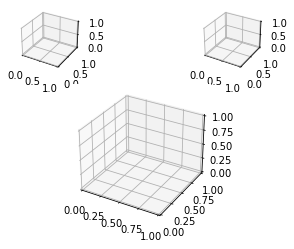

Output(layout=Layout(border='2px solid black'))

In [13]:
axes_lim = 3
window_size = 1000

[out, fig_iadd, ax_iadd_0, ax_iadd_1, ax_iadd_2] = create_output_widget(window_size)


def update_output(s1_x, s1_y, s1_z, s1_rx, s1_ry, s1_rz, s2_x, s2_y, s2_z, s2_rx, s2_ry, s2_rz):

    [parent_orientation, parent_coordinates] = get_orientation_and_location(s1_x, s1_y, s1_z, s1_rx, s1_ry, s1_rz)
    [child_orientation, child_coordinates] = get_orientation_and_location(s2_x, s2_y, s2_z, s2_rx, s2_ry, s2_rz)

    [lcs_parent, lcs_child, lcs_child_ref] = coordinate_system_addition(
        parent_orientation, parent_coordinates, child_orientation, child_coordinates
    )

    coordinates_cr = lcs_child_ref.coordinates
    cr_x = coordinates_cr[0]
    cr_y = coordinates_cr[1]
    cr_z = coordinates_cr[2]

    ax_iadd_0.clear()
    vs.plot_coordinate_system(lcs_ref, ax_iadd_0, color="r", label="reference")
    vs.plot_coordinate_system(lcs_parent, ax_iadd_0, color="g", label="parent")
    ax_iadd_0.plot([0, s1_x], [0, s1_y], [0, s1_z], "c--", label="ref -> parent")
    setup_axes(ax_iadd_0, axes_lim, "'parent' in reference coordinate system")

    ax_iadd_1.clear()
    vs.plot_coordinate_system(lcs_ref, ax_iadd_1, color="g", label="parent")
    vs.plot_coordinate_system(lcs_child, ax_iadd_1, color="y", label="child")
    ax_iadd_1.plot([0, s2_x], [0, s2_y], [0, s2_z], "m--", label="parent -> child")
    setup_axes(ax_iadd_1, axes_lim, "'child' in 'parent' coordinate system")

    ax_iadd_2.clear()
    vs.plot_coordinate_system(lcs_ref, ax_iadd_2, color="r", label="reference")
    vs.plot_coordinate_system(lcs_parent, ax_iadd_2, color="g", label="parent")
    vs.plot_coordinate_system(lcs_child_ref, ax_iadd_2, color="y", label="parent + child")
    ax_iadd_2.plot([0, s1_x], [0, s1_y], [0, s1_z], "c--", label="ref -> parent")
    ax_iadd_2.plot([s1_x, cr_x], [s1_y, cr_y], [s1_z, cr_z], "m--", label="parent -> child")
    setup_axes(ax_iadd_2, axes_lim * 2, "'parent' and 'child' in reference coordinate system")

create_interactive_plot(update_output, limit_loc=axes_lim, name_sys1="parent", name_sys2="child")
out

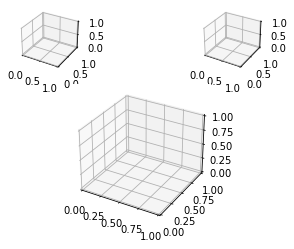

Output(layout=Layout(border='2px solid black'))

In [14]:
axes_lim = 1.5
window_size = 1000

[out_2, fig2, ax_isub_0, ax_isub_1, ax_isub_2] = create_output_widget(window_size)


def update_output2(s1_x, s1_y, s1_z, s1_rx, s1_ry, s1_rz, s2_x, s2_y, s2_z, s2_rx, s2_ry, s2_rz):

    [sys1_orientation, sys1_coordinates] = get_orientation_and_location(s1_x, s1_y, s1_z, s1_rx, s1_ry, s1_rz)
    [sys2_orientation, sys2_coordinates] = get_orientation_and_location(s2_x, s2_y, s2_z, s2_rx, s2_ry, s2_rz)

    [lcs_sys1_in_ref, lcs_sys2_in_ref, lcs_sys1_in_sys2, lcs_sys2_in_sys1] = coordinate_system_subtraction(
        sys1_orientation, sys1_coordinates, sys2_orientation, sys2_coordinates
    )
    sys12_o = lcs_sys1_in_sys2.coordinates
    sys12_x = sys12_o[0]
    sys12_y = sys12_o[1]
    sys12_z = sys12_o[2]

    sys21_o = lcs_sys2_in_sys1.coordinates
    sys21_x = sys21_o[0]
    sys21_y = sys21_o[1]
    sys21_z = sys21_o[2]

    ax_isub_1.clear()
    vs.plot_coordinate_system(lcs_ref, ax_isub_1, color="g", label="system 1 (reference)")
    vs.plot_coordinate_system(lcs_sys2_in_sys1, ax_isub_1, color="b", label="system 2 - system 1")
    ax_isub_1.plot([0, sys21_x], [0, sys21_y], [0, sys21_z], "y--", label="system 1 -> system 2")
    setup_axes(ax_isub_1, axes_lim * 2, "'system 2' in 'system 1'")

    ax_isub_0.clear()
    vs.plot_coordinate_system(lcs_ref, ax_isub_0, color="b", label="system 2 (reference)")
    vs.plot_coordinate_system(lcs_sys1_in_sys2, ax_isub_0, color="g", label="system_1 - system 2")
    ax_isub_0.plot([0, sys12_x], [0, sys12_y], [0, sys12_z], "y--", label="system 1 -> system 2")
    setup_axes(ax_isub_0, axes_lim * 2, "'system 1' in 'system 2'")

    ax_isub_2.clear()
    vs.plot_coordinate_system(lcs_ref, ax_isub_2, color="r", label="reference")
    vs.plot_coordinate_system(lcs_sys1_in_ref, ax_isub_2, color="g", label="system 1")
    vs.plot_coordinate_system(lcs_sys2_in_ref, ax_isub_2, color="b", label="system 2")
    ax_isub_2.plot([0, s1_x], [0, s1_y], [0, s1_z], "g--", label="ref -> system 1")
    ax_isub_2.plot([0, s2_x], [0, s2_y], [0, s2_z], "b--", label="ref -> system 2")
    ax_isub_2.plot([s1_x, s2_x], [s1_y, s2_y], [s1_z, s2_z], "y--", label="system 1 <-> system 2")
    setup_axes(ax_isub_2, axes_lim, "'system 1' and 'system 2' in reference coordinate system")


create_interactive_plot(update_output2, limit_loc=axes_lim)
out_2

## Invert method

The `invert` method calculates how a parent coordinate system is positioned and oriented in its child coordinate system:

~~~ python
lcs_child_in_parent = lcs_parent_in_child.invert()
~~~

Here is a short example with visualization:

In [15]:
lcs_child_in_parent = tf.LocalCoordinateSystem.from_euler(
    sequence="xy", angles=[90, 45], degrees=True, coordinates=[2, 3, 0]
)
lcs_parent_in_child = lcs_child_in_parent.invert()

**Plot:**

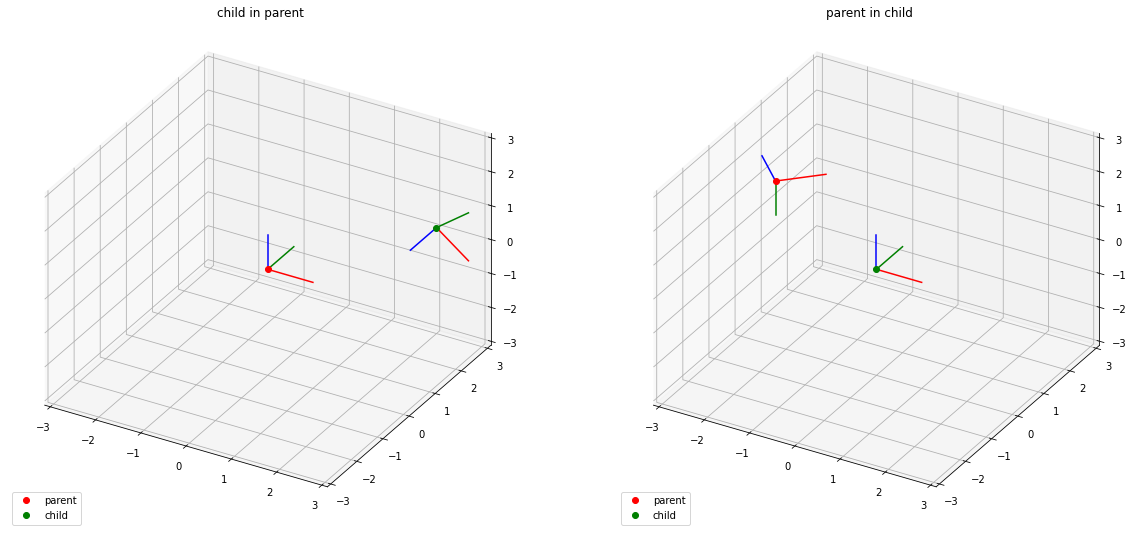

In [16]:
_, (ax_invert_0, ax_invert_1) = vs.new_3d_figure_and_axes(num_subplots=2, width=1000)

# left plot
vs.plot_coordinate_systems([(lcs_ref, {"color":"r", "label":"parent"}), 
                            (lcs_child_in_parent, {"color":"g", "label":"child"})],
                           axes=ax_invert_0,
                           limits=[-3, 3],
                           title="child in parent")
                        
# right plot
vs.plot_coordinate_systems([(lcs_parent_in_child, {"color":"r", "label":"parent"}), 
                            (lcs_ref, {"color":"g", "label":"child"})],
                           axes=ax_invert_1,
                           limits=[-3, 3],
                           title="parent in child")

## Time dependency

The orientation and position of a local coordinate system towards their reference system might vary in time. For example, in a welding process, the position of the torch towards the specimen is changing constantly. The `LocalCoordinateSystem` provides an interface for such cases. All previously shown construction methods also provide the option to pass a `time` parameter.

> **IMPORTANT HINT:** In the current package version, only the constructors `time` parameter is actually working

> **TODO:** Rewrite examples if factory methods also support time dependency

To create a time-dependent system, you have to provide a list of timestamps that can be converted to a `pandas.DateTimeIndex`. If you do, you also need to provide the extra data for the `orientation` and/or `coordinates` to the constructor or construction method. You do this by adding an extra outer dimension to the corresponding time-dependent function parameter. For example: If you want to create a moving coordinate system with 2 timestamps, you can do it by like this:

~~~ python
time = ["2010-02-01", "2010-02-02"]

 # fixed orientation (no extra dimension)
orientation_mov = [[0, -1, 0], [1, 0, 0], [0, 0, 1]]

# time dependent coordinates (extra dimension)
coordinates_mov = [[-3, 0, 0], [0, 0, 2]]

lcs_mov_in_ref = tf.LocalCoordinateSystem(orientation=orientation_mov, coordinates=coordinates_mov, time=time)
~~~

A coordinate system with varying orientation between 2 timestamps is defined by:

~~~ python
time = ["2010-02-01", "2010-02-02"]

# time dependent orientation (extra coordinate)
orientation_rot = [[[1, 0, 0], [0, 1, 0], [0, 0, 1]], [[0, -1, 0], [1, 0, 0], [0, 0, 1]]]

# fixed coordinates (no extra dimension)
coordinates_rot = [1, 0, 2]

lcs_rot_in_ref = tf.LocalCoordinateSystem(orientation=orientation_rot, coordinates=coordinates_rot, time=time)
~~~

You can also create a rotating and moving coordinate system:

~~~ python
time = ["2010-02-01", "2010-02-02"]

coordinates_movrot = [[0, 3, 0], [-2, 3, 2]]
orientation_movrot = [[[1, 0, 0], [0, 1, 0], [0, 0, 1]], [[0, -1, 0], [1, 0, 0], [0, 0, 1]]]

lcs_movrot_in_ref = tf.LocalCoordinateSystem(orientation=orientation_movrot, coordinates=coordinates_movrot, time=time)
~~~

You have to ensure, that the extra outer dimension has always the same number of entries as a number of timestamps you provided. Otherwise, an exception is raised. In case your coordinate system data is not always providing orientation and coordinates at the same time, you need to interpolate the missing values first.

Here is a visualization of the discussed coordinate systems at the two different times:

In [17]:
# define coordinate systems
time = ["2010-02-01", "2010-02-02"]

orientation_mov = [[0, -1, 0], [1, 0, 0], [0, 0, 1]]
coordinates_mov = [[-3, 0, 0], [0, 0, 2]]
lcs_mov_in_ref = tf.LocalCoordinateSystem(orientation=orientation_mov, coordinates=coordinates_mov, time=time)

orientation_rot = [[[1, 0, 0], [0, 1, 0], [0, 0, 1]], [[0, -1, 0], [1, 0, 0], [0, 0, 1]]]
coordinates_rot = [1, 0, 2]
lcs_rot_in_ref = tf.LocalCoordinateSystem(orientation=orientation_rot, coordinates=coordinates_rot, time=time)

coordinates_movrot = [[0, 3, 0], [-2, 3, 2]]
orientation_movrot = [[[1, 0, 0], [0, 1, 0], [0, 0, 1]], [[0, -1, 0], [1, 0, 0], [0, 0, 1]]]
lcs_movrot_in_ref = tf.LocalCoordinateSystem(orientation=orientation_movrot, coordinates=coordinates_movrot, time=time)

**Plot:**

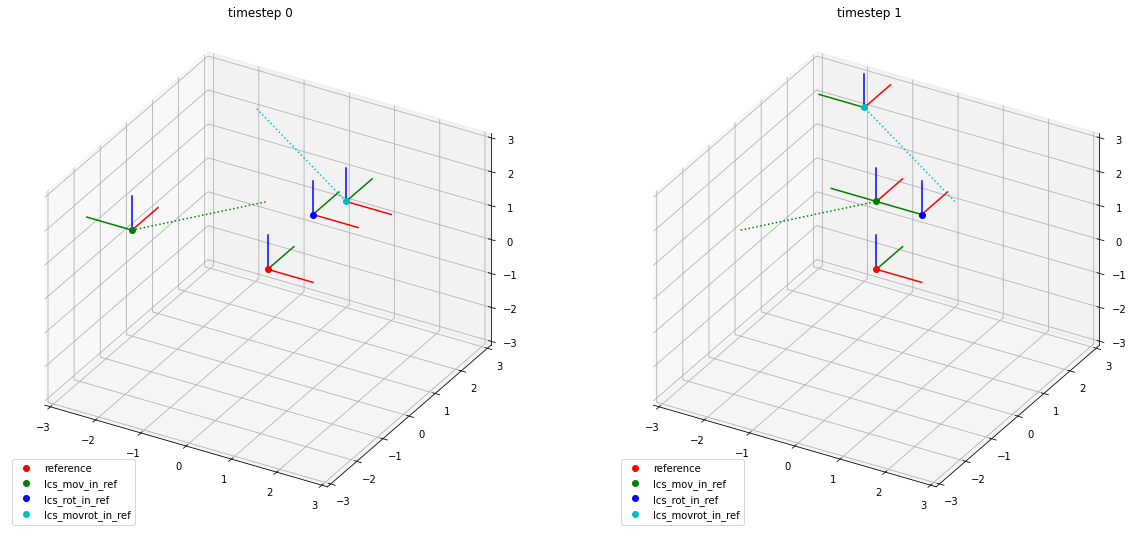

In [18]:
# plot coordinate systems
_, axes_array = vs.new_3d_figure_and_axes(num_subplots=2, width=1000)

for i, ax in enumerate(axes_array):
    vs.plot_coordinate_systems([(lcs_ref, {"color":"r", "label":"reference"}),
                                (lcs_mov_in_ref, {"color":"g", "label":"lcs_mov_in_ref"}),
                                (lcs_rot_in_ref, {"color":"b", "label":"lcs_rot_in_ref"}),
                                (lcs_movrot_in_ref, {"color":"c", "label":"lcs_movrot_in_ref"})],
                               axes=ax,
                               limits=[-3, 3],
                               title=f"timestep {i}",
                               time_index=i)


## Time interpolation

It is also possible, to interpolate a coordinate system's orientations and coordinates in time by using the `interp_time` function. You have to pass it a single or multiple target times for the interpolation. As for the constructor, you can pass any type that is convertible to a `pandas.DatetimeIndex`. Alternatively, you can pass another `LocalCoordinateSystem` which provides the target timestamps. The return value of this function is a new `LocalCoordinateSystem` with interpolated orientations and coordinates.

In case that a target time for the interpolation lies outside of the `LocalCoordinateSystem`s' time range, the boundary value is broadcasted.

Here is an example:

In [19]:
# original coordinate system
time = ["2010-02-02", "2010-02-07"]

coordinates_tdp = [[0, 3, 0], [-2, 3, 2]]
orientation_tdp = [[[1, 0, 0], [0, 1, 0], [0, 0, 1]], [[0, -1, 0], [1, 0, 0], [0, 0, 1]]]
lcs_tdp_in_ref = tf.LocalCoordinateSystem(orientation=orientation_movrot, coordinates=coordinates_movrot, time=time)

time_interp = pd.DatetimeIndex(["2010-02-01", "2010-02-03", "2010-02-04", "2010-02-05", "2010-02-06", "2010-02-11"])
lcs_interp_in_ref = lcs_tdp_in_ref.interp_time(time_interp)

**Plot:**

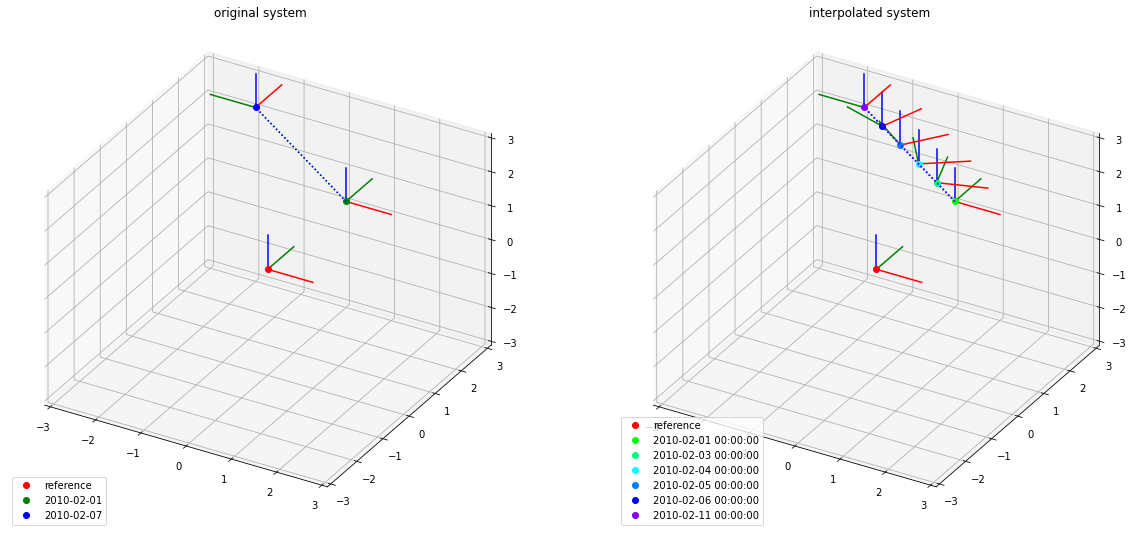

In [20]:
# plot coordinate systems
_, (ax_0_interp, ax_1_interp) = vs.new_3d_figure_and_axes(num_subplots=2, width=1000)

# original systems
vs.plot_coordinate_systems([(lcs_ref, {"color":"r", "label":"reference"}),
                            (lcs_tdp_in_ref, {"color":"g", "label":"2010-02-01", "time_index":0}),
                            (lcs_tdp_in_ref, {"color":"b", "label":"2010-02-07", "time_index":1})],
                           axes=ax_0_interp,
                           limits=[-3, 3],
                           title="original system")


# interpolated systems
colors = [[0, 1, 0], [0, 1, 0.5], [0, 1, 1], [0, 0.5, 1], [0, 0, 1], [0.5, 0, 1]]
plot_data = [
    (lcs_interp_in_ref, {"color":colors[i], "label":time_interp[i], "time_index":i}) 
    for i in range(len(time_interp))
]
plot_data = [(lcs_ref, {"color":"r", "label":"reference"}), *plot_data]

vs.plot_coordinate_systems(plot_data,
                           axes=ax_1_interp,
                           limits=[-3, 3],
                           title="interpolated system")

As you can see, the time values `"2010-02-01"` and `"2010-02-11"`, which lie outside the original range from `"2010-02-02"` and `"2010-02-07"`  still get valid values due to the broadcasting across time range boundaries. The intermediate coordinates and orientations are interpolated as expected.

> **TODO:** Mention interpolation behavior of `+` and `*`

## Transformation of spatial data

The `LocalCoordinateSystem` only defines how the different coordinate systems are oriented towards each other. If you want to transform spatial data which is defined in one coordinate system (for example specimen geometry/point cloud) you have to use the `CoordinateSystemManager`, which is discussed in the next tutorial or do the transformation manually.
For the manual transformation, you can get all you need from the `LocalCoordinateSystem` using its accessor properties:

~~~
orientation = lcs_a_in_b.orientation
coordinates = lcs_a_in_b.coordinates
~~~

The returned data is an `xarray.DataFrame`. In case you are not used to work with this data type, you can get a `numpy.ndarray` by simply using their `data` property:

~~~
orientation_numpy = lcs_a_in_b.orientation.data
coordinates_numpy = lcs_a_in_b.coordinates.data
~~~

Keep in mind, that you actually get an array of matrices (`orientation`) and vectors (`coordinates`) if the corresponding component is time dependent. The transformation itself is done by the equation:

$$v_b = O_{ab} \cdot v_a + c_{ab}$$

where $v_a$ is a data point defined in coordinate system `a`, $O_{ab}$ is the orientation matrix of `a` in `b`, $c_{ab}$ the coordinates of `a` in `b` and $v_b$ the transformed data point.


Here is a short example that transforms the points of a square from one coordinate system to another:

In [21]:
lcs_target_in_ref = tf.LocalCoordinateSystem.from_euler(
    sequence="zy", angles=[90, 45], degrees=True, coordinates=[2, -2, 0]
)
lcs_ref_in_target = lcs_target_in_ref.invert()

points_in_ref = np.array([[-1, 1, 0], [1, 1, 0], [1, -1, 0], [-1, -1, 0], [-1, 1, 0]], dtype=float).transpose()

# Transform points to target system
points_in_target = (
    np.matmul(lcs_ref_in_target.orientation.data, points_in_ref) + lcs_ref_in_target.coordinates.data[:, np.newaxis]
)

**Plot:**

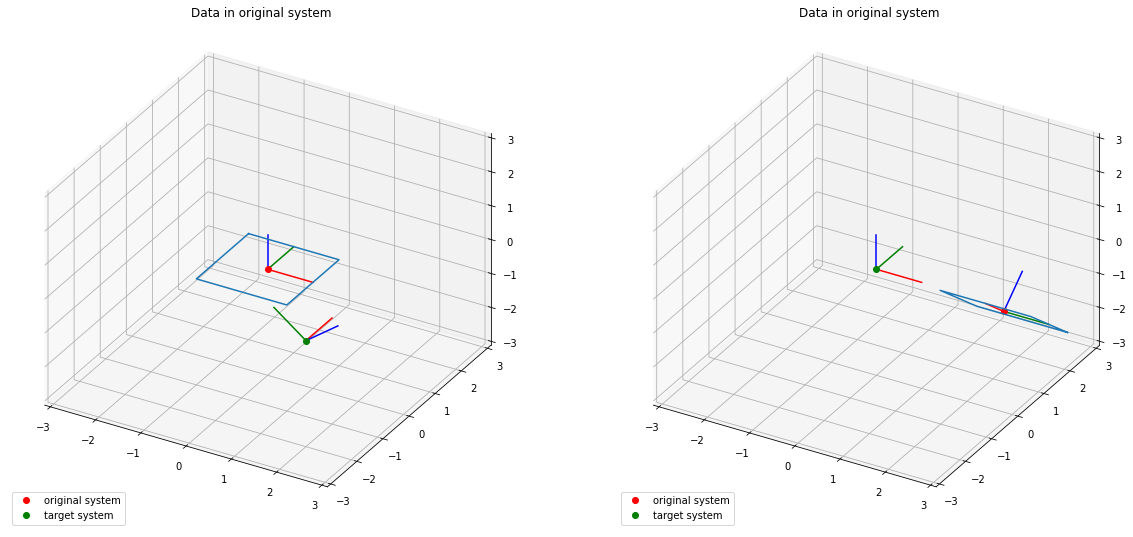

In [22]:
# plot coordinate systems
_, (ax_0_trans, ax_1_trans) = vs.new_3d_figure_and_axes(num_subplots=2, width=1000)

# first plot
vs.plot_coordinate_systems([(lcs_ref, {"color":"r", "label":"original system"}),
                            (lcs_target_in_ref, {"color":"g", "label":"target system"})],
                           axes=ax_0_trans,
                           limits=[-3, 3],
                           title="Data in original system")
ax_0_trans.plot(points_in_ref[0], points_in_ref[1], points_in_ref[2])


# second plot
vs.plot_coordinate_systems([(lcs_ref_in_target, {"color":"r", "label":"original system"}),
                            (lcs_ref, {"color":"g", "label":"target system"})],
                           axes=ax_1_trans,
                           limits=[-3, 3],
                           title="Data in original system")
ax_1_trans.plot(points_in_target[0], points_in_target[1], points_in_target[2])

## Internal xarray structure

The local coordinate system and many other components of the WeldX package use xarray data frames internally. So it is also possible to pass xarray data frames to a lot of functions and the constructor. However, they need a certain structure which will be described here. If you are not familiar with the xarray package, you should first read the [documentation](http://xarray.pydata.org/en/stable/).

To pass a xarray data frame as coordinate to a `LocalCoordinateSystem`, it must at least have a dimension `c`. It represents the location in 3d space of the coordinate system and must always be of length 3. Those components must be named coordinates of the data frame (`coords={"c": ["x", "y", "z"]}`). An optional dimension is `time`. It can be of arbitrary length, but the timestamps must be added as coordinates.

The same conventions that are used for the coordinates also apply to the orientations. Additionally, they must have another dimension `v` of length 3, which are enumerated (`"v": [0, 1, 2]`). `c` and `v` are the rows and columns of the orientation matrix.

**Example:**

In [23]:
time = pd.TimedeltaIndex([0,5],"D")
coordinates_tdp = [[0, 3, 0], [-2, 3, 2]]
orientation_tdp = [[[1, 0, 0], [0, 1, 0], [0, 0, 1]], [[0, -1, 0], [1, 0, 0], [0, 0, 1]]]

dsx_coordinates = xr.DataArray(data=coordinates_tdp, dims=["time", "c"], coords={"time": time, "c": ["x", "y", "z"]})
dsx_orientation = xr.DataArray(
    data=orientation_tdp, dims=["time", "c", "v"], coords={"time": time, "c": ["x", "y", "z"], "v": [0, 1, 2]},
)

lcs_xr = tf.LocalCoordinateSystem(orientation=dsx_orientation, coordinates=dsx_coordinates)

**Plot:**

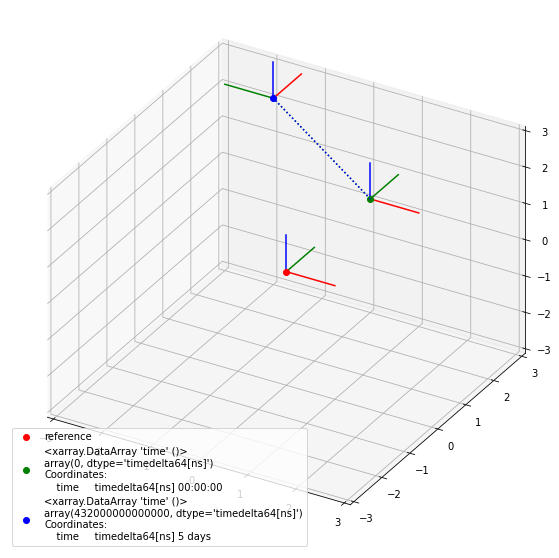

In [24]:
# plot coordinate systems
_, ax_dsx = vs.new_3d_figure_and_axes()

# first timestep
vs.plot_coordinate_systems([(lcs_ref, {"color":"r", "label":"reference"}),
                            (lcs_xr, {"color":"g", "label":str(lcs_xr.time[0]), "time_index":0}),
                            (lcs_xr, {"color":"b", "label":str(lcs_xr.time[1]), "time_index":1})],
                           axes=ax_dsx,
                           limits=[-3, 3])

The `weldx.utility` package contains two utility functions to create xarray data frames that can be passed as `orientation` and `coordinates` to an `LocalCoordinateSystem`. They are named `xr_3d_vector` and `xr_3d_matrix`. Please read the API documentation for further information.